In [ ]:
# create folders inside this Colab session
import os
os.makedirs('/content/data', exist_ok=True)
os.makedirs('/content/outputs/figures', exist_ok=True)
print("Folders ready at /content")

Folders ready at /content


In [ ]:
# create a small synthetic sessions dataset
import pandas as pd, numpy as np
from datetime import date, timedelta
np.random.seed(42)

n = 1200
start = date.today() - timedelta(days=90)

sources = ["google","facebook","instagram","email","direct","referral","tiktok"]
mediums = {
    "google": ["cpc","organic","brand_search"],
    "facebook": ["paid_social","organic"],
    "instagram": ["paid_social","organic"],
    "email": ["email"],
    "direct": ["none"],
    "referral": ["referral"],
    "tiktok": ["paid_social","organic"]
}
campaigns = ["spring_sale","brand_awareness","remarketing","newsletter","influencer","none"]

# base conversion and cost for a few paid mediums
base_conv = {
    ("google","cpc"): 0.035, ("google","brand_search"): 0.055,
    ("google","organic"): 0.018, ("facebook","paid_social"): 0.020,
    ("instagram","paid_social"): 0.014, ("email","email"): 0.030,
    ("referral","referral"): 0.015, ("direct","none"): 0.022,
    ("tiktok","paid_social"): 0.012, ("tiktok","organic"): 0.003,
    ("facebook","organic"): 0.006, ("instagram","organic"): 0.004,
}
base_cpc = {("google","cpc"):0.55, ("google","brand_search"):0.35,
            ("facebook","paid_social"):0.40, ("instagram","paid_social"):0.38,
            ("tiktok","paid_social"):0.25}

rows = []
for i in range(n):
    d = start + timedelta(days=int(np.random.randint(0, 90)))
    src = np.random.choice(sources, p=[0.30,0.20,0.12,0.08,0.15,0.08,0.07])
    med = np.random.choice(mediums[src])
    camp = np.random.choice(campaigns)
    pages = max(1, int(np.random.exponential(2.0)) + (1 if med in ["brand_search","email","cpc"] else 0))
    add_to_cart = 1 if np.random.rand() < (0.08 + (0.03 if pages>=2 else 0)) else 0
    checkout = 1 if (add_to_cart and np.random.rand() < 0.45) else 0
    conv_rate = base_conv.get((src,med), 0.01)
    purchase = 1 if (checkout and np.random.rand() < max(conv_rate/0.036, 0.05)) else 0
    cost = 0.0
    if (src,med) in base_cpc:
        cost = round(abs(np.random.normal(base_cpc[(src,med)]*(1+0.1*(pages-1)), 0.1)), 2)
    elif med == "paid_social":
        cost = round(abs(np.random.normal(0.35*(1+0.1*(pages-1)), 0.1)), 2)

    rows.append({
        "session_id": f"S{i+1:05d}",
        "user_id": f"U{np.random.randint(1,400):04d}" if np.random.rand()>0.12 else np.nan,
        "date": d.isoformat(),
        "source": src, "medium": med, "campaign": camp,
        "pages": pages, "added_to_cart": add_to_cart, "checkout": checkout,
        "purchase": purchase, "cost": cost
    })

df = pd.DataFrame(rows)
df.to_csv('/content/data/sessions.csv', index=False)
print("Wrote /content/data/sessions.csv with", len(df), "rows")
df.head()

Wrote /content/data/sessions.csv with 1200 rows


,session_id,user_id,date,source,medium,campaign,pages,added_to_cart,checkout,purchase,cost
0,S00001,U0360,2025-07-12,tiktok,paid_social,influencer,1,0,0,0,0.24
1,S00002,U0192,2025-06-14,email,email,influencer,8,0,0,0,0.00
2,S00003,U0188,2025-07-20,google,organic,none,1,1,0,0,0.00
3,S00004,U0131,2025-08-09,google,organic,none,1,0,0,0,0.00
4,S00005,U0242,2025-07-11,email,email,spring_sale,1,0,0,0,0.00


In [ ]:
# imports + set paths
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

DATA = Path('/content/data')
OUT  = Path('/content/outputs')
FIG  = OUT / 'figures'
print('Paths set:', DATA, OUT, FIG, sep='\n- ')
print('Data file exists?', (DATA/'sessions.csv').exists())

Paths set:
- /content/data
- /content/outputs
- /content/outputs/figures
Data file exists? True


In [ ]:
# load CSV and quick look
df = pd.read_csv(DATA / 'sessions.csv')
print("Rows:", len(df))
df.head()

Rows: 1200


,session_id,user_id,date,source,medium,campaign,pages,added_to_cart,checkout,purchase,cost
0,S00001,U0360,2025-07-12,tiktok,paid_social,influencer,1,0,0,0,0.24
1,S00002,U0192,2025-06-14,email,email,influencer,8,0,0,0,0.00
2,S00003,U0188,2025-07-20,google,organic,none,1,1,0,0,0.00
3,S00004,U0131,2025-08-09,google,organic,none,1,0,0,0,0.00
4,S00005,U0242,2025-07-11,email,email,spring_sale,1,0,0,0,0.00


In [ ]:
# basic cleaning
df['date'] = pd.to_datetime(df['date'], errors='coerce')
for c in ['pages','added_to_cart','checkout','purchase','cost']:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# qualified = 2+ pages OR added_to_cart
df['is_qualified'] = ((df['pages']>=2) | (df['added_to_cart']==1)).astype(int)

print("Nulls per column:\n", df.isnull().sum())
print("\nDate range:", df['date'].min().date(), "→", df['date'].max().date())

Nulls per column:
 session_id         0
user_id          151
date               0
source             0
medium             0
campaign           0
pages              0
added_to_cart      0
checkout           0
purchase           0
cost               0
is_qualified       0
dtype: int64

Date range: 2025-05-22 → 2025-08-19


In [ ]:
# performance by source/medium/campaign
channel = (df
  .groupby(['source','medium','campaign'], dropna=False)
  .agg(sessions=('session_id','nunique'),
       qualified=('is_qualified','sum'),
       purchases=('purchase','sum'),
       cost=('cost','sum'))
  .reset_index())

channel['ctr_q']    = (channel['qualified']/channel['sessions']).round(4)
channel['conv_rate']= (channel['purchases']/channel['sessions']).round(4)
channel['cpa']      = (channel['cost']/channel['purchases'].replace(0, np.nan)).round(2)

channel.to_csv(OUT/'channel_summary.csv', index=False)
channel.sort_values(['cpa','conv_rate'], ascending=[True, False]).head(10)

,source,medium,campaign,sessions,qualified,purchases,cost,ctr_q,conv_rate,cpa
38,google,organic,newsletter,22,9,3,0.0,0.4091,0.1364,0.0
46,instagram,organic,remarketing,10,5,1,0.0,0.5000,0.1000,0.0
37,google,organic,influencer,22,10,2,0.0,0.4545,0.0909,0.0
6,email,email,brand_awareness,12,7,1,0.0,0.5833,0.0833,0.0
1,direct,none,influencer,27,14,2,0.0,0.5185,0.0741,0.0
39,google,organic,none,27,13,2,0.0,0.4815,0.0741,0.0
59,referral,referral,spring_sale,15,5,1,0.0,0.3333,0.0667,0.0
56,referral,referral,newsletter,18,8,1,0.0,0.4444,0.0556,0.0
41,google,organic,spring_sale,21,11,1,0.0,0.5238,0.0476,0.0
40,google,organic,remarketing,23,13,1,0.0,0.5652,0.0435,0.0


In [ ]:
# funnel: landing → product → cart → checkout → purchase
funnel = (df
  .assign(landing=1,
          product=(df['pages']>=1).astype(int),
          cart=df['added_to_cart'],
          checkout=df['checkout'],
          purchase=df['purchase'])
  .melt(id_vars=['source','medium','campaign'],
        value_vars=['landing','product','cart','checkout','purchase'],
        var_name='stage', value_name='hit')
  .groupby(['source','medium','campaign','stage'])['hit'].sum()
  .reset_index())

funnel.to_csv(OUT/'funnel_summary.csv', index=False)
funnel.head(10)

,source,medium,campaign,stage,hit
0,direct,none,brand_awareness,cart,1
1,direct,none,brand_awareness,checkout,0
2,direct,none,brand_awareness,landing,30
3,direct,none,brand_awareness,product,30
4,direct,none,brand_awareness,purchase,0
5,direct,none,influencer,cart,2
6,direct,none,influencer,checkout,2
7,direct,none,influencer,landing,27
8,direct,none,influencer,product,27
9,direct,none,influencer,purchase,2


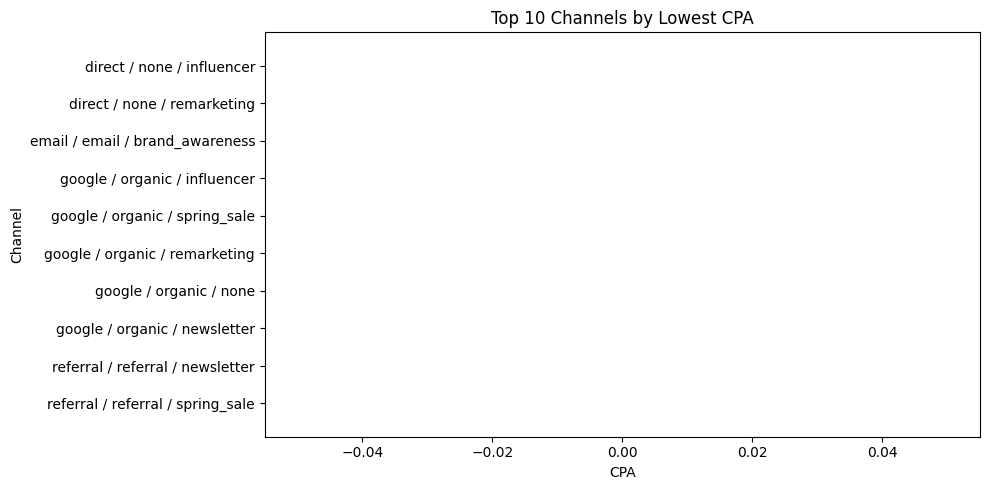

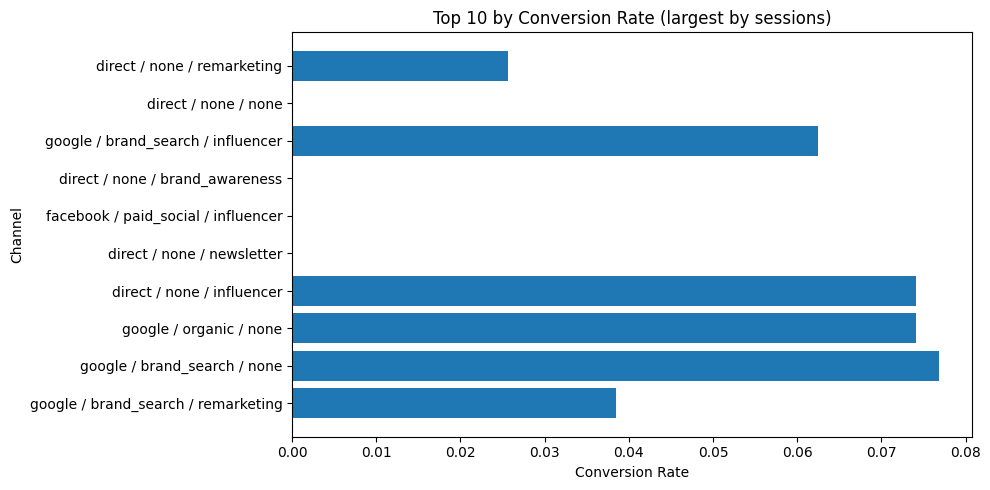

Saved charts to: /content/outputs/figures


In [ ]:
# charts
# 1) CPA (lower is better)
cp = channel[channel['purchases']>0].copy()
cp['channel_name'] = cp['source']+" / "+cp['medium']+" / "+cp['campaign']
cp = cp.sort_values('cpa').head(10)

plt.figure(figsize=(10,5))
plt.barh(cp['channel_name'], cp['cpa'])
plt.xlabel('CPA'); plt.ylabel('Channel'); plt.title('Top 10 Channels by Lowest CPA')
plt.gca().invert_yaxis(); plt.tight_layout()
plt.savefig(FIG/'cpa_by_channel.png', dpi=160)
plt.show()

# 2) Conversion rate (higher is better among biggest channels)
cv = channel.copy()
cv['channel_name'] = cv['source']+" / "+cv['medium']+" / "+cv['campaign']
cv = cv.sort_values('sessions', ascending=False).head(10)

plt.figure(figsize=(10,5))
plt.barh(cv['channel_name'], cv['conv_rate'])
plt.xlabel('Conversion Rate'); plt.ylabel('Channel'); plt.title('Top 10 by Conversion Rate (largest by sessions)')
plt.gca().invert_yaxis(); plt.tight_layout()
plt.savefig(FIG/'conversion_rate_by_channel.png', dpi=160)
plt.show()

print("Saved charts to:", FIG)

In [ ]:
# write a short brief draft
start_date = df['date'].min().date()
end_date   = df['date'].max().date()

top_cpa = (channel[channel['purchases']>0]
           .sort_values('cpa').head(3))[['source','medium','campaign','cpa']]
top_cr  = channel.sort_values('conv_rate', ascending=False).head(3)[['source','medium','campaign','conv_rate']]

lines = []
lines += [f"# Insight Brief — Campaign Performance",
          f"**Data window:** {start_date} to {end_date}",
          f"**What this is:** Quick read on channel efficiency and funnel leaks.",
          "",
          "## 1) Top insights (edit me)",
          "- …",
          "- …",
          "- …",
          "",
          "## 2) Funnel leakage (edit me)",
          "- Biggest drop: …  Hypothesis: …  Action: …",
          "",
          "## 3) Quick stats"]
lines += ["**Top CPA channels:**"] + [f"- {r.source}/{r.medium}/{r.campaign}: CPA {r.cpa}" for r in top_cpa.itertuples()]
lines += ["", "**Top Conversion Rate channels:**"] + [f"- {r.source}/{r.medium}/{r.campaign}: CR {round(r.conv_rate,4)}" for r in top_cr.itertuples()]

path = OUT/'brief_draft.md'
with open(path, 'w', encoding='utf-8') as f:
    f.write("\n".join(lines))

print("Wrote:", path)

Wrote: /content/outputs/brief_draft.md


In [ ]:
# Paid-only CPA leaderboard
paid = channel[(channel['cost']>0) & (channel['purchases']>0)].copy()
print("Top paid channels by CPA:")
print(paid.sort_values('cpa').head(5)[['source','medium','campaign','sessions','purchases','cpa','conv_rate']])

# Whole-site funnel drop-offs
stages = df.assign(
    landing=1,
    product=(df['pages']>=1).astype(int),
    cart=df['added_to_cart'],
    checkout=df['checkout'],
    purchase=df['purchase']
)[['landing','product','cart','checkout','purchase']].sum()

drops = {
  'landing→product': 1 - stages['product']/stages['landing'],
  'product→cart': 1 - stages['cart']/stages['product'],
  'cart→checkout': 1 - stages['checkout']/stages['cart'],
  'checkout→purchase': 1 - stages['purchase']/stages['checkout'],
}
print("\nDrop-off by stage:")
for k,v in drops.items():
    print(f"{k}: {v:.2%}")

Top paid channels by CPA:
       source        medium     campaign  sessions  purchases   cpa  conv_rate
70     tiktok   paid_social  remarketing        10          1  3.27     0.1000
29     google  brand_search  spring_sale        20          2  3.80     0.1000
32     google           cpc   newsletter        18          2  4.88     0.1111
27     google  brand_search         none        26          2  5.08     0.0769
50  instagram   paid_social   newsletter        14          1  5.91     0.0714

Drop-off by stage:
landing→product: 0.00%
product→cart: 89.92%
cart→checkout: 48.76%
checkout→purchase: 45.16%
